## Import library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import dataset dan memahaminya

In [2]:
df = pd.read_csv("data/drug200.csv")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
Age            200 non-null int64
Sex            200 non-null object
BP             200 non-null object
Cholesterol    200 non-null object
Na_to_K        200 non-null float64
Drug           200 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

<p><b>- Age :</b> Umur dari pasien</p>
<p><b>- Sex :</b> Gender dari pasien</p>
<p><b>- BP (bloodpressure) :</b> Tekanan darah dari pasien</p>
<p><b>- Cholesterol :</b> Kolestrol dari pasien</p>
<p><b>- Na_to_K :</b> Rasio Natrium dan kalium pada darah pasien</p>
<p><b>- Drug :</b> Jenis Obat</p>

## EDA dan visualisasi

### Age

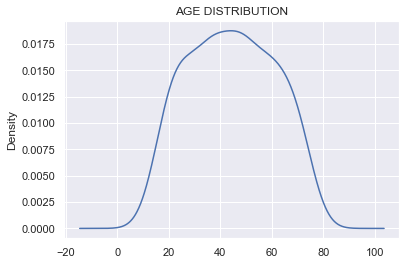

In [5]:
plt.title("AGE DISTRIBUTION")
df['Age'].plot(kind='kde')
plt.show()

In [6]:
print(f"Rata-rata umur dari pasien : {df['Age'].mean()}")

Rata-rata umur dari pasien : 44.315


<h5>Rata-rata umur pasien adalah sekitar 44 tahun</h5>

### Sex

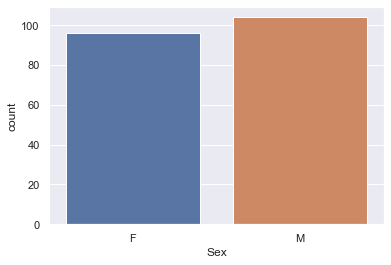

In [7]:
sns.countplot(x=df['Sex'])

<h5>Distribusi laki-laki dan perempuan hampir merata</h5>

### Drug

In [8]:
df['Drug'].value_counts()

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

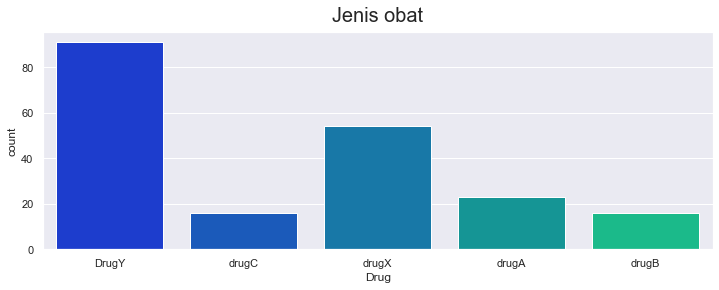

In [9]:
plt.figure(figsize=[12,4])
plt.title("Jenis obat", fontsize=20, y=1.02)
sns.countplot(x = df['Drug'], palette="winter")
plt.show()

<h5>Obat jenis Y paling sering digunakan dan obat jenis C dan B paling jarang digunakan</h5>

### Melihat sebaran jenis obat dalam rentang umur berdasarkan gender

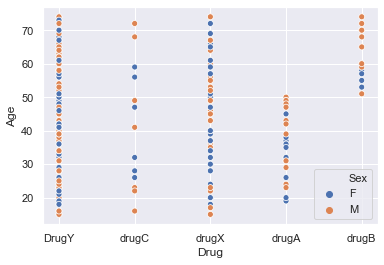

In [10]:
sns.scatterplot(x='Drug', y='Age', hue='Sex',data=df)
plt.show()

<h5>Obat jenis Y dan X memiliki sebaran paling merata, Obat jenis A memiliki rentang penyebaran diumur 19-50, Obat jenis B memiliki rentang penyebaran diumur 50-75</h5>

### BP (Blood Pressure)

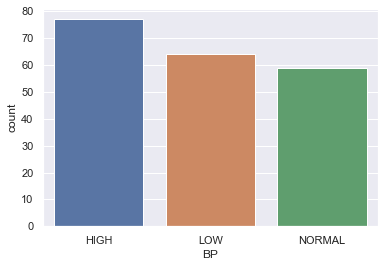

In [11]:
sns.countplot(x=df['BP'])

<h5>Orang dengan tekanan darah tinggi adalah orang yg paling sering menggunakan obat diikuti dengan tekanan darah rendah dan tekanan darah normal</h5>

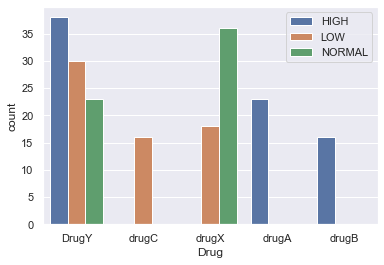

In [12]:
sns.countplot(x='Drug',hue='BP',data = df)
plt.legend(loc='upper right')
plt.show()

<h5>Obat jenis C hanya digunakan oleh orang dengan tekanan darah rendah, Obat jenis A dan B hanya digunakan oleh orang dengan tekanan darah tinggi</h5>

### Cholestrol

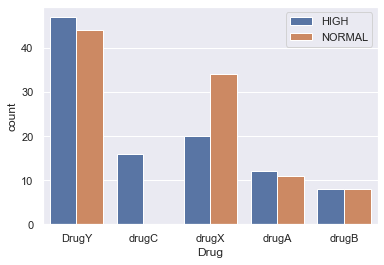

In [13]:
sns.countplot(x='Drug',hue='Cholesterol',data = df)
plt.legend(loc='upper right')
plt.show()

<h5>Obat jenis C hanya digunakan oleh orang dengan kolestrol tinggi</h5>

### Na_to_K (Natrium dan kalium)

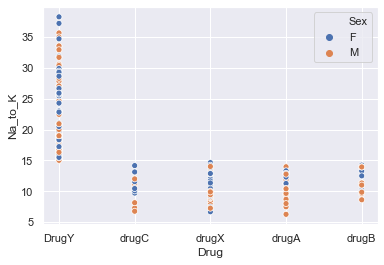

In [14]:
sns.scatterplot(x='Drug', y='Na_to_K', hue='Sex',data=df)
plt.show()

<h5>Obat jenis Y digunakan oleh orang dengan rasio Natrium dan kalium diatas 15 dan obat yang lainnya digunakan oleh orang dengan rasio Natrium dan kalium dibawah 15</h5>

### Categorical columns

In [15]:
df['Sex'] = df['Sex'].map({'M': 1, 'F': 2})
df['BP'] = df['BP'].map({'HIGH': 1, "NORMAL" : 2, "LOW" : 3})
df['Cholesterol'] = df['Cholesterol'].map({'HIGH': 1, "NORMAL" : 2})
df["Drug"] = df["Drug"].map({"DrugY":1, "drugC":2, "drugX":3, "drugA":4, "drugB":5})

## Splitting Dataset

In [16]:
X = df.drop(columns="Drug")
y = df["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 5), (40, 5), (160,), (40,))

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [18]:
X_train

,Age,Sex,BP,Cholesterol,Na_to_K
79,32,2,3,2,10.840
197,52,1,2,1,9.894
38,39,2,2,2,9.709
24,33,2,3,1,33.486
122,34,1,2,1,22.456
...,...,...,...,...,...
106,22,1,2,1,11.953
14,50,2,2,1,12.703
92,29,2,1,1,29.450
179,67,2,2,1,15.891


In [26]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["Age", "Na_to_K"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Sex", "BP", "Cholesterol"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   14.5s finished


{'algo__max_depth': 59, 'algo__max_features': 0.737265320016441, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 187, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
1.0 0.9937106918238993 1.0


In [22]:
from jcopml.plot import plot_confusion_matrix


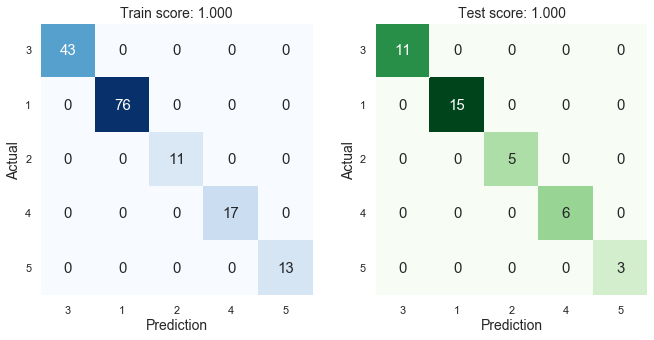

In [23]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)
